# 2 shapely 2.0重要新特性一览

## 2.1 向量化矢量操作带来高达百倍的性能提升

In [1]:
import shapely
shapely.__version__

'2.0.0'

In [2]:
import numpy as np
from shapely import Polygon, Point

# 构造示例要素，以判断面要素是否包含点要素为例
polygon1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
points = [Point(i*0.1, i*0.1) for i in range(10000)]
points_array = np.array(points)

In [3]:
%%timeit
# 常规的标量一对一运算
_ = [polygon1.contains(point) for point in points]

97.6 ms ± 32.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
# 已有的要素列表批量运算
shapely.contains(polygon1, points)

23.1 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit
# 新的向量化运算支持
shapely.contains(polygon1, points_array)

295 µs ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 2.2 矢量对象不可变

In [6]:
# 矢量要素对象充当字典的键
point1 = Point(0.231, 1.3213)
demo_dict = {point1: 999}
demo_dict

{<POINT (0.231 1.321)>: 999}

In [7]:
demo_dict[point1]

999

In [8]:
# 矢量要素作为pandas的分组运算依据
import geopandas as gpd

demo_gdf = gpd.GeoDataFrame({
    'value': np.random.rand(10),
    'geometry': [Point(i % 2, i % 2) for i in range(10)]
})
demo_gdf.head(3)

,value,geometry
0,0.775280,POINT (0.00000 0.00000)
1,0.971165,POINT (1.00000 1.00000)
2,0.520033,POINT (0.00000 0.00000)


In [9]:
# 注意要设置sort=False
demo_gdf.groupby('geometry', sort=False).agg({'value': 'sum'})

,value
geometry,
POINT (0.00000 0.00000),3.350294
POINT (1.00000 1.00000),2.929552


## 2.3 矢量要素类可作为顶级API使用

In [10]:
# 新的可选导入方式
from shapely import (
    Point, LineString, LinearRing, Polygon, box,
    MultiPoint, MultiLineString, MultiPolygon
)

## 2.4 多部件要素不再可视作序列型对象

In [11]:
multi_points1 = MultiPoint([Point(i, i) for i in range(5)])
try:
    multi_points1[0]
except Exception as e:
    print(e)
try:
    list(multi_points1)
except Exception as e:
    print(e)

'MultiPoint' object is not subscriptable
'MultiPoint' object is not iterable


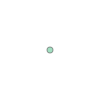

In [12]:
# 新的迭代方式：使用其geoms属性
multi_points1.geoms[0]

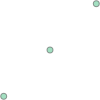

In [13]:
multi_points1.geoms[1:-1]

In [14]:
list(multi_points1.geoms)

[<POINT (0 0)>, <POINT (1 1)>, <POINT (2 2)>, <POINT (3 3)>, <POINT (4 4)>]

## 2.5 矢量要素支持精度控制

In [15]:
# set_precision第2个参数用于设置精度阈值，当输入要素坐标精度超出此阈值精度时会被取整
point2 = shapely.set_precision(Point(0.999999, 0.999999), 0.001)
point2.x, point2.y

(1.0, 1.0)

In [16]:
point3 = shapely.set_precision(Point(0.999999, 0.999999), 0.000001)
point3.x, point3.y

(0.999999, 0.999999)

In [17]:
shapely.get_precision(point2)

0.001

In [18]:
shapely.get_precision(point3)

1e-06

## 2.6 基于GEOS新增大量新功能函数

In [19]:
# 查看当前底层GEOS依赖库版本
shapely.geos_version_string

'3.11.1'

- extract_unique_points()

In [20]:
# 去重后剩余3个点要素
(
    shapely
    .extract_unique_points(
            LineString(
            [
                Point(i, i)
                for i in [1, 2, 3, 2, 1]
            ]
        )
    )
    .geoms
    .__len__()
)

3

- node()

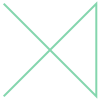

In [21]:
node_line_demo = LineString(
    [
        (0, 0), (1, 1), (1, 0), (0, 1)
    ]
)
node_line_demo

In [22]:
len(shapely.node(node_line_demo).geoms)

3

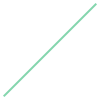

In [23]:
shapely.node(node_line_demo).geoms[0]

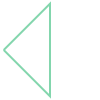

In [24]:
shapely.node(node_line_demo).geoms[1]

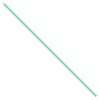

In [25]:
shapely.node(node_line_demo).geoms[2]

- minimum_bounding_circle()与minimum_bounding_radius()

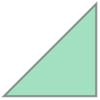

In [26]:
demo_polygon = Polygon([(0, 0), (1, 0), (1, 1)])
demo_polygon

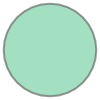

In [27]:
shapely.minimum_bounding_circle(demo_polygon)

In [28]:
shapely.minimum_bounding_radius(demo_polygon)

0.7071067811865476

In [29]:
2 ** 0.5 / 2

0.7071067811865476

- dwithin()

In [30]:
dwithin_demo_point = Point(0, 0)
shapely.dwithin(dwithin_demo_point, Point(1, 1), 1.5)

True

In [31]:
shapely.dwithin(dwithin_demo_point, Point(1, 1), 1)

False

In [32]:
# 批量判断
shapely.dwithin(dwithin_demo_point, 
                np.array([Point(i, i) for i in range(-3, 3)]),
                1.5)

array([False, False,  True,  True,  True, False])

## 2.7 新增force_2d()、force_3d()函数

In [33]:
# 利用get_coordinate_dimension()可以查询目标要素的坐标维度
# 强制3d转2d
shapely.get_coordinate_dimension(shapely.force_2d(Point(0, 0, 0)))

2

In [34]:
# 强制2d转3d
shapely.get_coordinate_dimension(shapely.force_3d(Point(0, 0)))

3